In [107]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [108]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())

Files already downloaded and verified


In [109]:
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

In [110]:
classes=dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [111]:
classes_dict={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

Label: horse


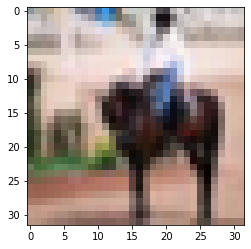

In [112]:
image, label = dataset[11]
plt.imshow(image.permute(1, 2, 0))
print('Label:', classes_dict[label])

image.shape: torch.Size([3, 32, 32])
Label: frog


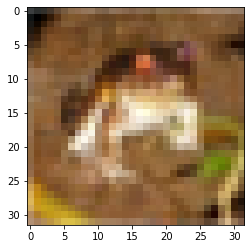

In [113]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', classes_dict[label])

In [114]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [115]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


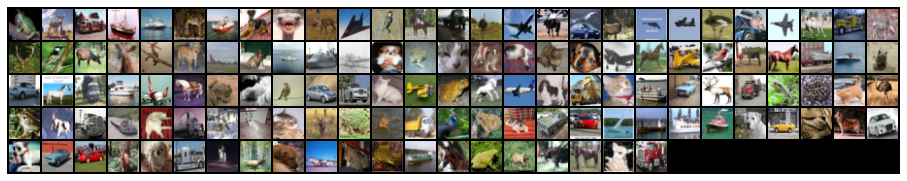

In [116]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=27).permute((1, 2, 0)))
    break

In [117]:
# As we see the Image Size is 32 * 32 = 1024 input size

In [118]:
class cifar10_Model(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, hidden_size1,hidden_size2, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # hidden layer 2
        self.linear2 = nn.Linear(hidden_size1,hidden_size2)
        # output layer 3
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer -1 
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer -2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [119]:
input_size = 3*32*32
hidden_size1 = 256
hidden_size2 = 128
num_classes = 10

In [120]:
model = cifar10_Model(input_size, hidden_size1,hidden_size2, out_size=num_classes)

In [121]:
model

cifar10_Model(
  (linear1): Linear(in_features=3072, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)

In [122]:
for t in model.parameters():
    print(t.shape)

torch.Size([256, 3072])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


In [123]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.299339532852173
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0279, -0.0482, -0.0430, -0.2143,  0.0290,  0.1147, -0.1138,  0.0643,
         -0.1136,  0.1389],
        [ 0.0003, -0.1084, -0.0477, -0.1962,  0.0032,  0.0989, -0.0878,  0.0459,
         -0.0962,  0.1638]])


In [124]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [125]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [126]:
device = get_default_device()
device

device(type='cuda')

In [127]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [128]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 3, 32, 32])
cuda:0


In [129]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [130]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [131]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [132]:
# Model (on GPU)
model = cifar10_Model(input_size, hidden_size1=hidden_size1,hidden_size2=hidden_size2, out_size=num_classes)
to_device(model, device)

cifar10_Model(
  (linear1): Linear(in_features=3072, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)

In [135]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.306981086730957, 'val_acc': 0.10439453274011612}]

In [136]:
history+=fit(5, 1e-1, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9641, val_acc: 0.2621
Epoch [1], val_loss: 1.7656, val_acc: 0.3604
Epoch [2], val_loss: 1.9733, val_acc: 0.3024
Epoch [3], val_loss: 1.7250, val_acc: 0.3744
Epoch [4], val_loss: 1.6385, val_acc: 0.4138


In [138]:
history+=fit(5, 1e-2, model, train_loader, val_loader)

Epoch [0], val_loss: 1.5323, val_acc: 0.4550
Epoch [1], val_loss: 1.5264, val_acc: 0.4563
Epoch [2], val_loss: 1.5170, val_acc: 0.4580
Epoch [3], val_loss: 1.5114, val_acc: 0.4612
Epoch [4], val_loss: 1.5029, val_acc: 0.4656


In [139]:
history+=fit(5, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4983, val_acc: 0.4657
Epoch [1], val_loss: 1.4978, val_acc: 0.4660
Epoch [2], val_loss: 1.4973, val_acc: 0.4664
Epoch [3], val_loss: 1.4969, val_acc: 0.4668
Epoch [4], val_loss: 1.4960, val_acc: 0.4663


In [140]:
history+=fit(5, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4959, val_acc: 0.4673
Epoch [1], val_loss: 1.4959, val_acc: 0.4672
Epoch [2], val_loss: 1.4958, val_acc: 0.4668
Epoch [3], val_loss: 1.4958, val_acc: 0.4671
Epoch [4], val_loss: 1.4957, val_acc: 0.4668


In [141]:
history+=fit(5, 1e-5, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4957, val_acc: 0.4669
Epoch [1], val_loss: 1.4957, val_acc: 0.4669
Epoch [2], val_loss: 1.4957, val_acc: 0.4669
Epoch [3], val_loss: 1.4957, val_acc: 0.4669
Epoch [4], val_loss: 1.4957, val_acc: 0.4668


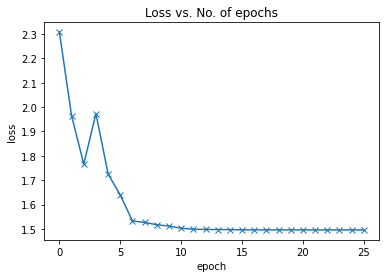

In [142]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

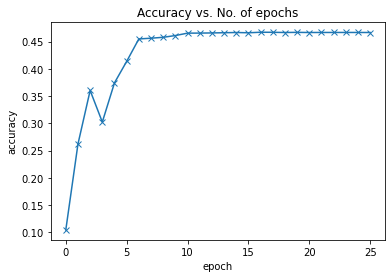

In [143]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### Testing with individual images

In [145]:
# Define test dataset
test_dataset = CIFAR10(root='data/', 
                     train=False,
                     transform=ToTensor())

In [146]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: truck , Predicted: truck


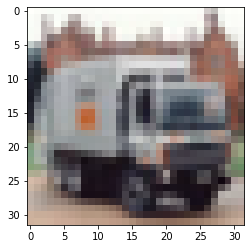

In [155]:
img, label = test_dataset[11]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes_dict[label], ', Predicted:', classes_dict[predict_image(img, model)])

Label: deer , Predicted: dog


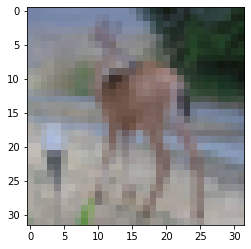

In [158]:
img, label = test_dataset[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes_dict[label], ', Predicted:', classes_dict[predict_image(img, model)])